In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('transaction_data.csv')
data=data.drop_duplicates()

#Checking for missing values in the dataset
data.isnull().sum(axis=0)

UserId                       0
TransactionId                0
TransactionTime              0
ItemCode                     0
ItemDescription           1454
NumberOfItemsPurchased       0
CostPerItem                  0
Country                      0
dtype: int64

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536572 entries, 0 to 1081501
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserId                  536572 non-null  int64  
 1   TransactionId           536572 non-null  int64  
 2   TransactionTime         536572 non-null  object 
 3   ItemCode                536572 non-null  int64  
 4   ItemDescription         535118 non-null  object 
 5   NumberOfItemsPurchased  536572 non-null  int64  
 6   CostPerItem             536572 non-null  float64
 7   Country                 536572 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 36.8+ MB


In [4]:
data.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [5]:
#Checking for wrong values in NumberOfItemsPurchased and CostPerItem
print(data.NumberOfItemsPurchased.min(),'\n',data.CostPerItem.min())
print(data.NumberOfItemsPurchased.max(),'\n',data.CostPerItem.max())

-242985 
 -15265.64
242985 
 1696285.44


In [6]:
data.NumberOfItemsPurchased.sort_values(ascending=False).head(10)

510647    242985
528376    222645
158382     37620
731850     16704
447048     14400
392207     12900
500565     12000
435734     11718
102131      9558
351064      9342
Name: NumberOfItemsPurchased, dtype: int64

In [7]:
data.CostPerItem.sort_values(ascending=False).head(10)

320282    1696285.44
638800      53778.60
253730      24614.32
404502      23305.47
246651      22706.12
816366      18687.04
940702      18687.04
412980      18687.04
207957      18595.22
383525      15989.37
Name: CostPerItem, dtype: float64

In [8]:
#Filtering out records with wrong values
data = data[(data['NumberOfItemsPurchased']>0)]
data = data[(data['CostPerItem']>0)]
data = data[(data['NumberOfItemsPurchased']<10000)]
data = data[(data['CostPerItem']<10000)]

#Adding new column depicting total amount
data['TotalAmount'] = data['NumberOfItemsPurchased'] * data['CostPerItem']

In [9]:
#Converting the string date field to datetime
data['TransactionTime'] = pd.to_datetime(data['TransactionTime'])

C:\Users\kesha\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [10]:
#Only taking transactions between feb 1,2018 and march 1,2019
start_date = '01-02-2018'
end_date = '01-03-2019'
mask = (data['TransactionTime'] > start_date) & (data['TransactionTime'] < end_date)

data = data.loc[mask]

In [11]:
#Customer distribution by country
country_data=data[['Country','UserId']].drop_duplicates()
country_data.groupby(['Country'])['UserId'].aggregate('count').reset_index().sort_values('UserId', ascending=False)

,Country,UserId
36,United Kingdom,3486
14,Germany,86
13,France,81
3,Belgium,25
31,Spain,25
33,Switzerland,19
27,Portugal,16
19,Italy,10
1,Austria,10
12,Finland,9


In [12]:
data=data.drop(['ItemCode','ItemDescription','NumberOfItemsPurchased','CostPerItem'],axis=1)
data.head()

,UserId,TransactionId,TransactionTime,Country,TotalAmount
1,337701,6283376,2018-12-26 09:06:00,United Kingdom,10.56
3,380478,6044973,2018-06-22 07:14:00,United Kingdom,5.19
4,-1,6143225,2018-09-10 11:58:00,United Kingdom,10.20
6,345954,6162981,2018-09-28 10:51:00,United Kingdom,61.56
7,-1,6143225,2018-09-10 11:58:00,United Kingdom,138.00


# RFM Modelling

In [13]:
#Recency = Latest Date - Last transaction, Frequency = no.of transactionId of transaction(s), Monetary = Sum of TotalAmount
import datetime as dt

#Latest date = 2019-01-03 as last Transaction was on 2019-01-02,to calculate the days from recent purchase
Latest_Date = dt.datetime(2019,1,3)

In [14]:
#Creating RFM Modelling scores for each customer
RFMScores = data.groupby('UserId').agg({'TransactionTime': lambda x: (Latest_Date - x.max()).days, 'TransactionId': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Converting TransactionTime into type int
RFMScores['TransactionTime'] = RFMScores['TransactionTime'].astype(int)

#Renaming column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'TransactionTime': 'Recency', 
                         'TransactionId': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,UserId,Recency,Frequency,Monetary
0,-1,0,100271,4899737.70
1,259287,80,93,8625.24
2,259308,26,31,7481.52
3,259350,261,17,1387.20
4,259392,23,70,9091.86


count    3863.000000
mean       91.585555
std        91.025983
min         0.000000
25%        18.000000
50%        51.000000
75%       150.000000
max       324.000000
Name: Recency, dtype: float64


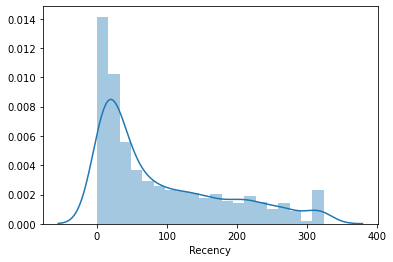

count      3863.000000
mean        102.536371
std        1621.187778
min           1.000000
25%          15.000000
50%          36.000000
75%          84.500000
max      100271.000000
Name: Frequency, dtype: float64


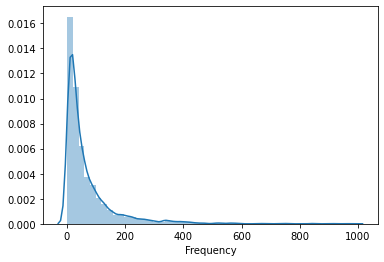

count    3.863000e+03
mean     8.556990e+03
std      8.454557e+04
min      1.203000e+01
25%      1.198785e+03
50%      2.562330e+03
75%      6.172800e+03
max      4.899738e+06
Name: Monetary, dtype: float64


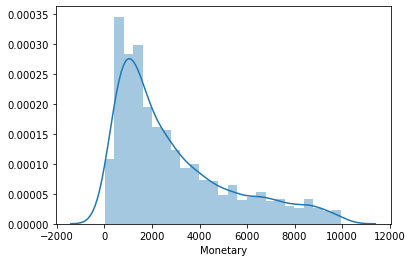

In [15]:
print(RFMScores.Recency.describe())
sns.distplot(RFMScores['Recency'])
plt.show()
print(RFMScores.Frequency.describe())
sns.distplot(RFMScores.query('Frequency < 1000')['Frequency']) #Frequency less than 1000
plt.show()
print(RFMScores.Monetary.describe())
sns.distplot(RFMScores.query('Monetary < 10000')['Monetary']) #Monetary less than 10000
plt.show()

In [16]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [17]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
UserId,,,,,,
-1,0,100271,4899737.70,1,1,1
259287,80,93,8625.24,3,1,1
259308,26,31,7481.52,2,3,1
259350,261,17,1387.20,4,3,3
259392,23,70,9091.86,2,2,1


In [18]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
UserId,,,,,,,,
-1,0,100271,4899737.70,1,1,1,111,3
259287,80,93,8625.24,3,1,1,311,5
259308,26,31,7481.52,2,3,1,231,6
259350,261,17,1387.20,4,3,3,433,10
259392,23,70,9091.86,2,2,1,221,5


In [19]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,UserId,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,-1,0,100271,4899737.70,1,1,1,111,3,Platinum
1,259287,80,93,8625.24,3,1,1,311,5,Platinum
2,259308,26,31,7481.52,2,3,1,231,6,Gold
3,259350,261,17,1387.20,4,3,3,433,10,Silver
4,259392,23,70,9091.86,2,2,1,221,5,Platinum


In [20]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
new_data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [21]:
new_data.head()

,Recency,Frequency,Monetary
UserId,,,
-1,0.000,11.516,15.405
259287,4.382,4.533,9.062
259308,3.258,3.434,8.920
259350,5.565,2.833,7.235
259392,3.135,4.248,9.115


## Plots after log transformation

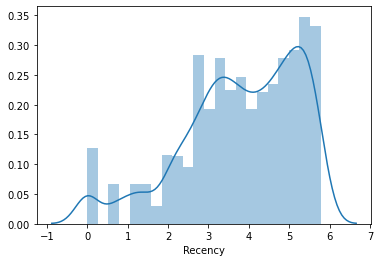

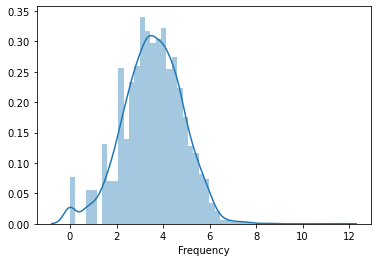

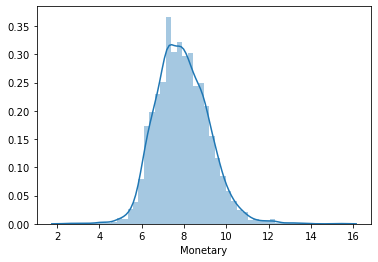

In [22]:
sns.distplot(new_data['Recency'])
plt.show()
sns.distplot(new_data.query('Frequency < 1000')['Frequency']) #Frequency less than 1000
plt.show()
sns.distplot(new_data.query('Monetary < 10000')['Monetary']) #Monetary less than 10000
plt.show()

# K-Means Clustering

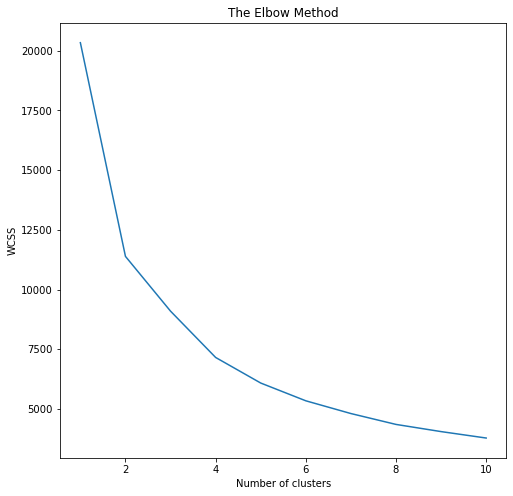

In [30]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(new_data)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(8,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [38]:
# Training the K-Means model on the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(new_data)

#clusters for the observation given in the dataset
RFMScores['Cluster'] = kmeans.labels_

Colors = ["red", "green", "blue", 'magenta']
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])

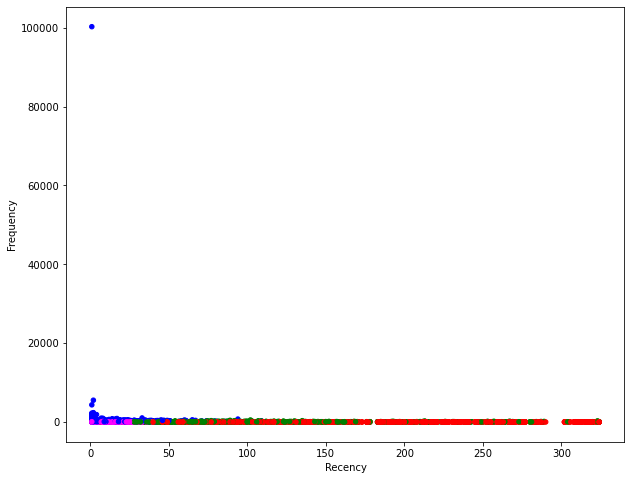

In [37]:
##Scatter Plot Frequency Vs Recency
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color'],
    s=20
)

In [39]:
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
UserId,,,,,,,,,,,
-1,1,100271,4899737.70,1,1,1,111,3,Platinum,2,blue
259287,80,93,8625.24,3,1,1,311,5,Platinum,1,green
259308,26,31,7481.52,2,3,1,231,6,Gold,1,green
259350,261,17,1387.20,4,3,3,433,10,Silver,0,red
259392,23,70,9091.86,2,2,1,221,5,Platinum,2,blue


In [52]:
final_data=RFMScores.reset_index()
final_data=final_data.rename(columns={'RFM_Loyalty_Level':'Segment'})
final_data[['UserId', 'Segment', 'Cluster', 'Color']].to_csv('output.csv', index=False)